# Imputing Missing Data with Random Forests
Using random forests to impute missing data.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('../')

from src.visualization import visualize

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import LogNorm, ListedColormap, LinearSegmentedColormap

import seaborn as sns

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 200)
import scipy
import math
import statsmodels.api as sm

from datetime import datetime, timedelta

# Data Import
For each imputation method, we have two datasets we consider:
1. Example data to test the accuracy of the model
2. Remaining participant data that we can apply the model to. 

## Example Data

In [6]:
data_ex = pd.read_csv("../data/interim/imputation/beacon-example_data-ux_s20.csv", parse_dates=["timestamp"],index_col="timestamp",infer_datetime_format=True)
# dropping the unecessary id columns
data_ex.drop(["pm1_number","pm2p5_number","pm10_number","pm1_mass","pm10_mass","rh"],axis="columns",inplace=True)
data_ex.head()

,tvoc,co,co2,pm2p5_mass,temperature_c,beiwe
timestamp,,,,,,
2020-06-09 00:06:00,19.356528,11.113153,946.397754,12.848364,28.612080,xlw5ntd5
2020-06-09 00:08:00,19.356528,10.941344,950.334084,12.948489,28.647230,xlw5ntd5
2020-06-09 00:10:00,19.356528,10.755647,955.023464,12.859584,28.679567,xlw5ntd5
2020-06-09 00:12:00,19.356528,10.568089,959.786123,12.662818,28.709417,xlw5ntd5
2020-06-09 00:14:00,19.356528,10.355479,964.260127,12.542290,28.737056,xlw5ntd5


## All Data

In [9]:
data = pd.read_csv("../data/processed/beacon-ux_s20.csv",parse_dates=["timestamp"],index_col="timestamp",infer_datetime_format=True)
# dropping the unecessary id columns
data.drop(["pm1_number","pm2p5_number","pm10_number","pm1_mass","pm10_mass","rh","no2","fitbit","redcap","lux","rh"],axis="columns",inplace=True)
data.head()

,tvoc,co,co2,pm2p5_mass,temperature_c,beacon,beiwe
timestamp,,,,,,,
2020-06-08 13:00:00,59.283485,11.627447,NaN,24.767709,16.244700,1,kyj367pi
2020-06-08 13:02:00,59.501238,11.612331,NaN,25.379307,16.257887,1,kyj367pi
2020-06-08 13:04:00,60.484807,11.598771,NaN,24.874103,16.269523,1,kyj367pi
2020-06-08 13:06:00,61.532057,11.579456,NaN,24.503767,16.279865,1,kyj367pi
2020-06-08 13:08:00,62.381287,11.567426,NaN,24.824221,16.289119,1,kyj367pi


# Helper Functions
Some helpful functions that we will probably call from time to time.

In [3]:
def scale_data(df):
    """scales the data in each column between 0 and 1 based on min-max"""
    scaler = MinMaxScaler()
    for col in df.columns:
        try:
            df[col] = scaler.fit_transform(df[col].values.reshape(-1, 1))
        except ValueError:
            pass
        
    return df

In [4]:
def get_beacon(df,bb):
    """gets data specific to the given beacon"""
    return df[df["beacon"] == bb]

In [5]:
def get_timing(s_time,e_time):
    """gets the seconds between the two time periods"""
    return round((e_time - s_time).total_seconds(),1)

In [6]:
def resample_data(df,minutes):
    """resamples the data to the given frequency"""
    if isinstance(df.index,pd.DatetimeIndex):
        return df.resample(f"{minutes}T").mean()
    else:
        try:
            df.set_index("timestamp",inplace=True)
            return df.resample(f"{minutes}T").mean()
        except KeyError:
            print("Need to set index as datetime")
            return df

# Table and Heatmap Generation
Creating some tables/heatmaps to visualize the data and pre-process it.

In [17]:
def get_table(df,bb,param="co2",minutes=60,plot=False):
    """returns a tabular form of the given parameter with date on x and hour on y"""
    data_by_beacon = get_beacon(df,bb)
    data_by_beacon.dropna(inplace=True)
    data_by_beacon = data_by_beacon.resample(f"{minutes}T").mean()
    data_by_beacon["hour"] = data_by_beacon.index.hour
    data_by_beacon["day"] = pd.to_datetime(data_by_beacon.index.date)
    df_to_return = data_by_beacon.pivot(index="day",columns="hour",values=param)
    if plot and len(df_to_return) > 0:
        fig, ax = plt.subplots(figsize=(16,8))
        sns.heatmap(data=df_to_return,ax=ax,cmap="Blues")
        
        ax.set_xlabel("Hour of Day")
        
        ax.set_ylabel("Day")
        t = []
        for label in ax.get_yticklabels():
            t.append(label.get_text()[:10])
        ax.set_yticklabels(t)
        
        ax.set_title(f"Beacon {bb}")
        
        plt.show()
        plt.close()
        
    return df_to_return

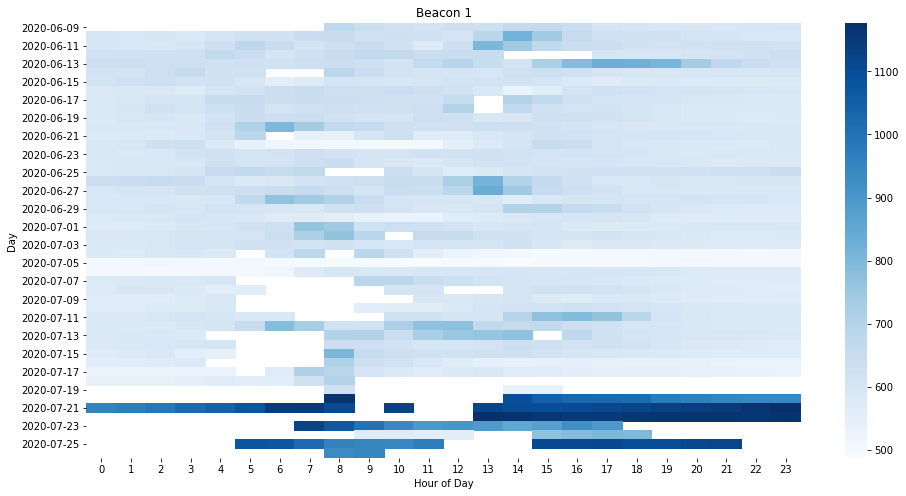

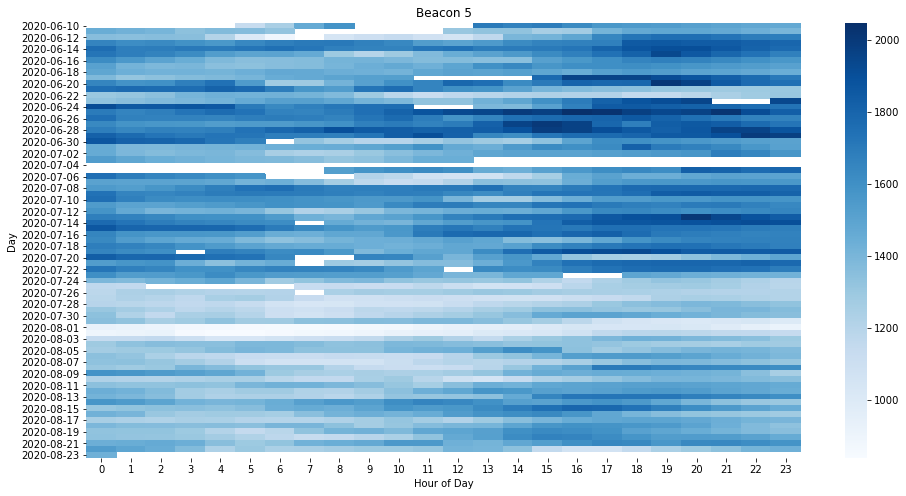

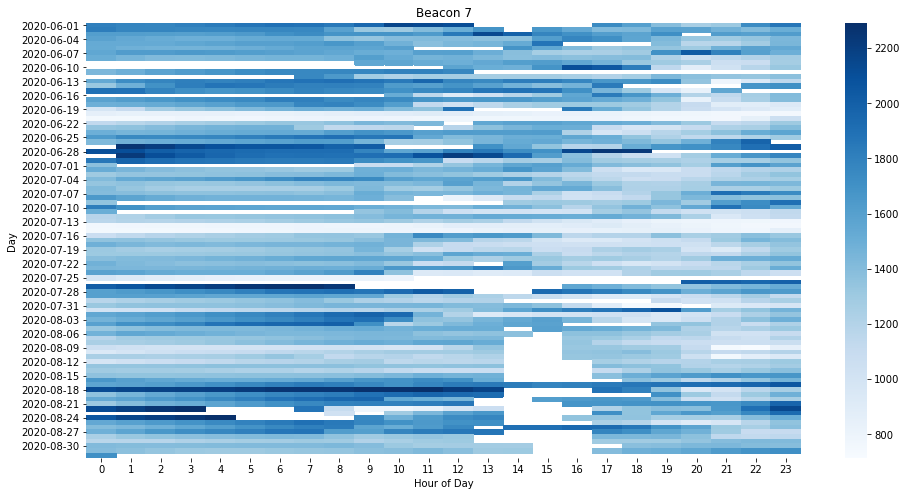

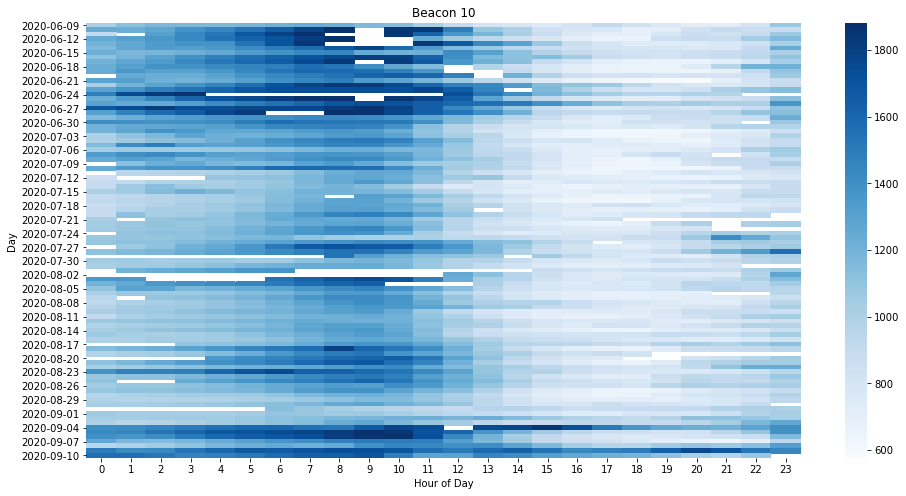

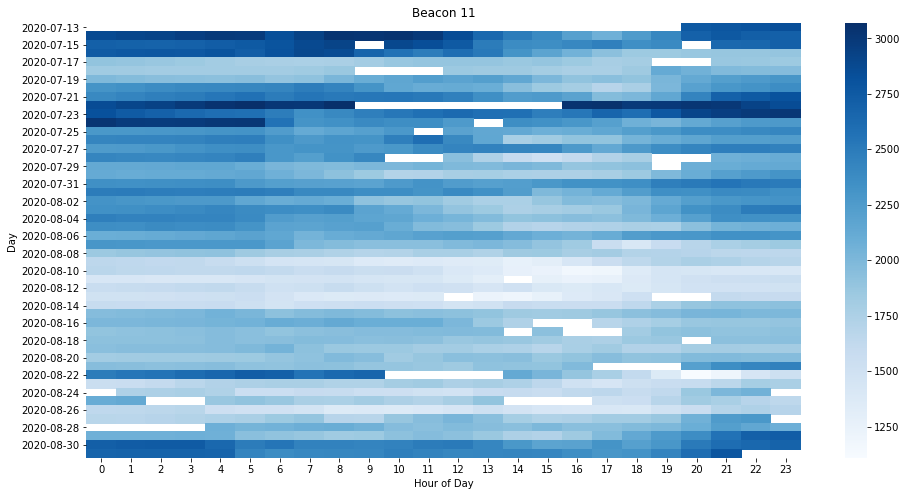

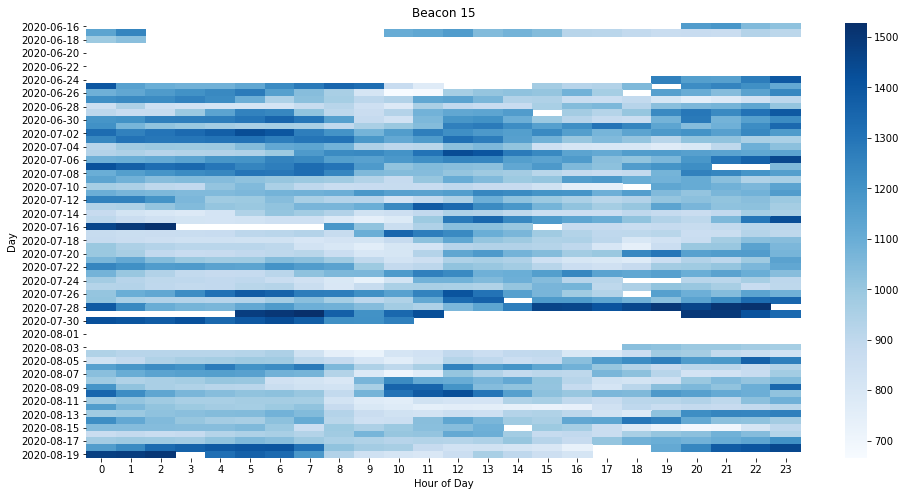

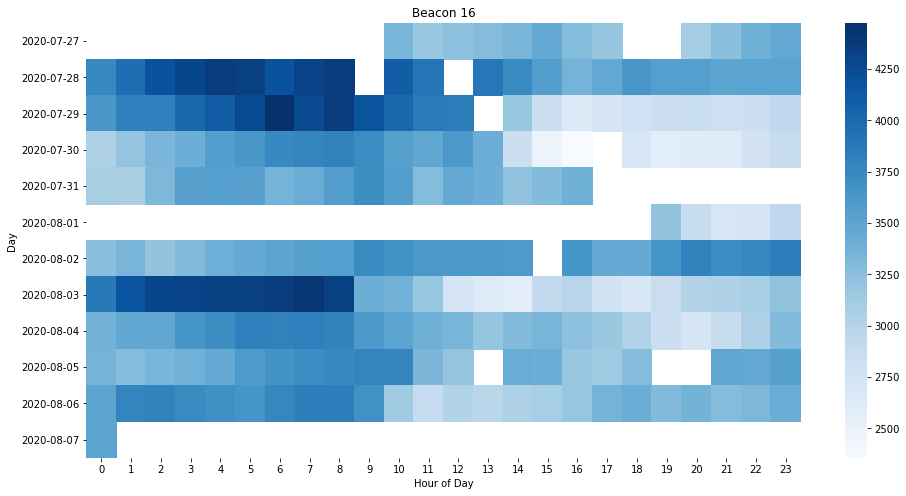

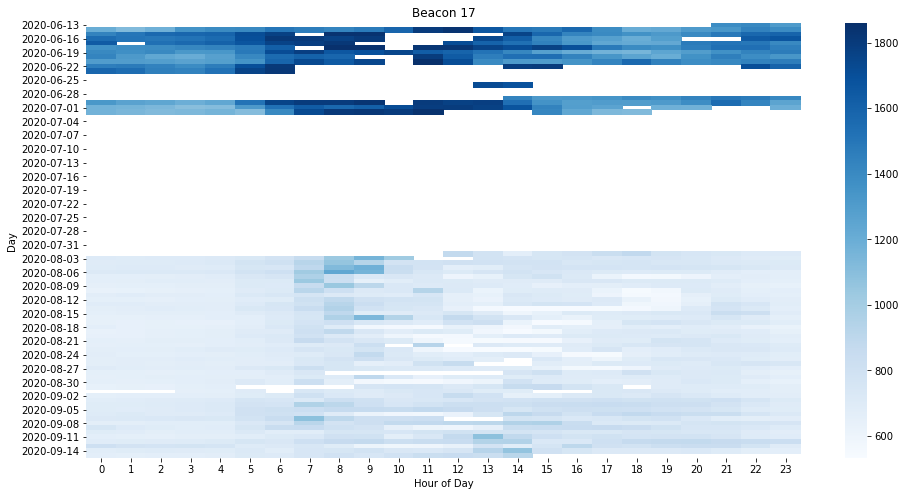

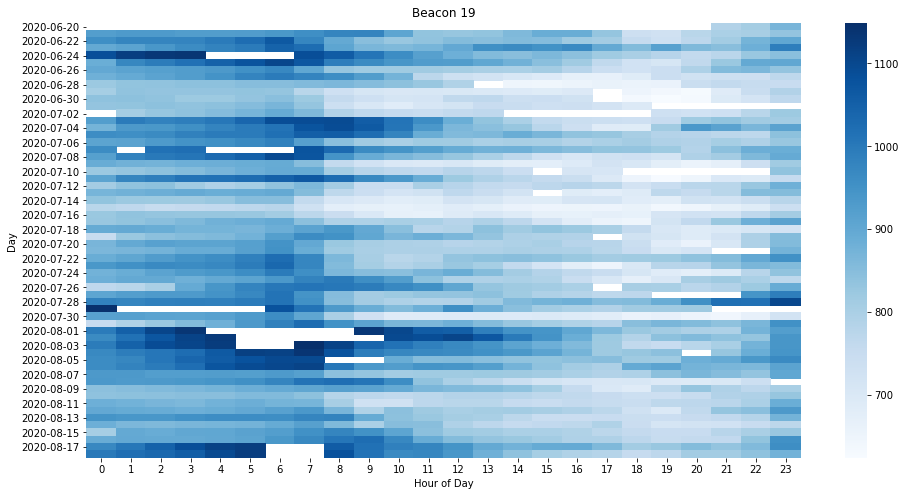

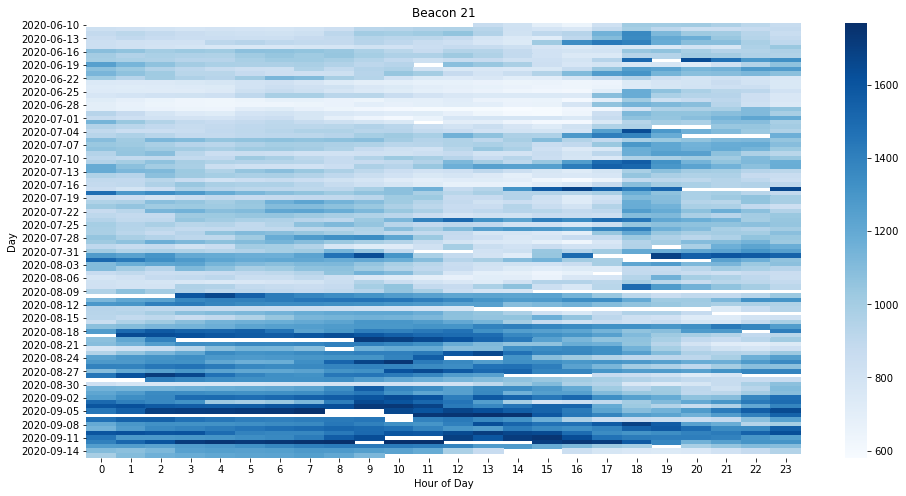

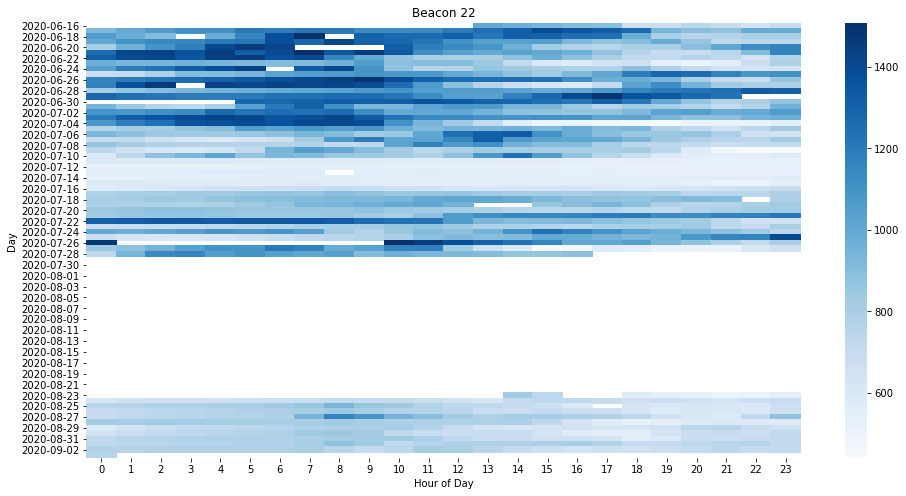

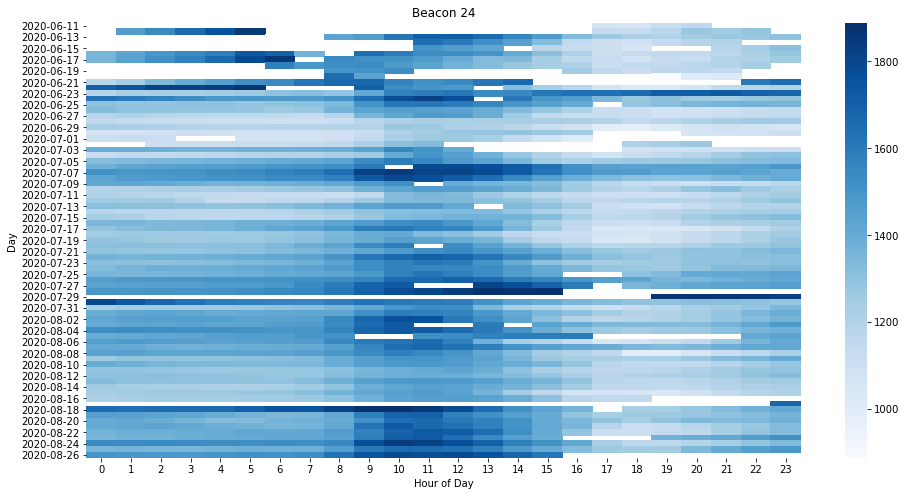

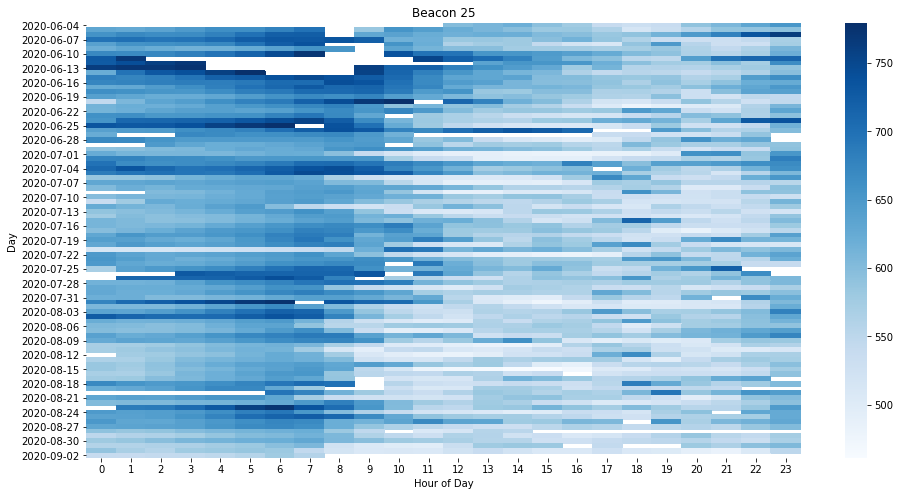

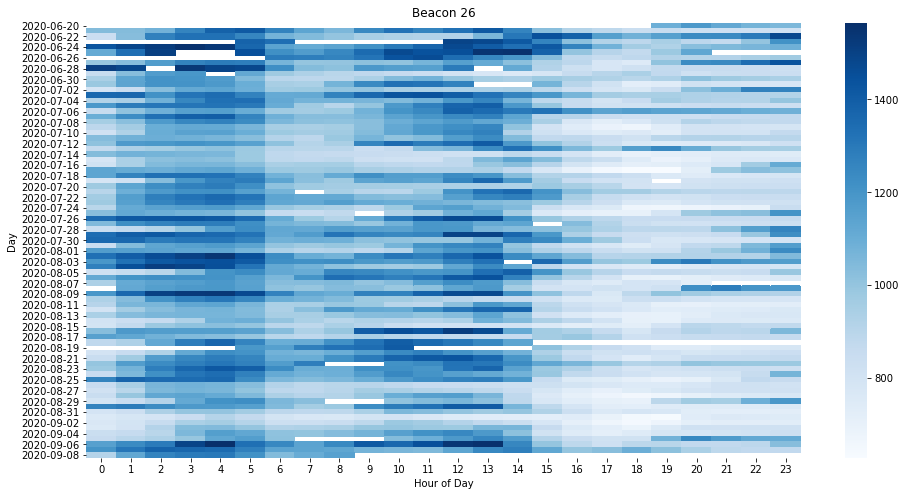

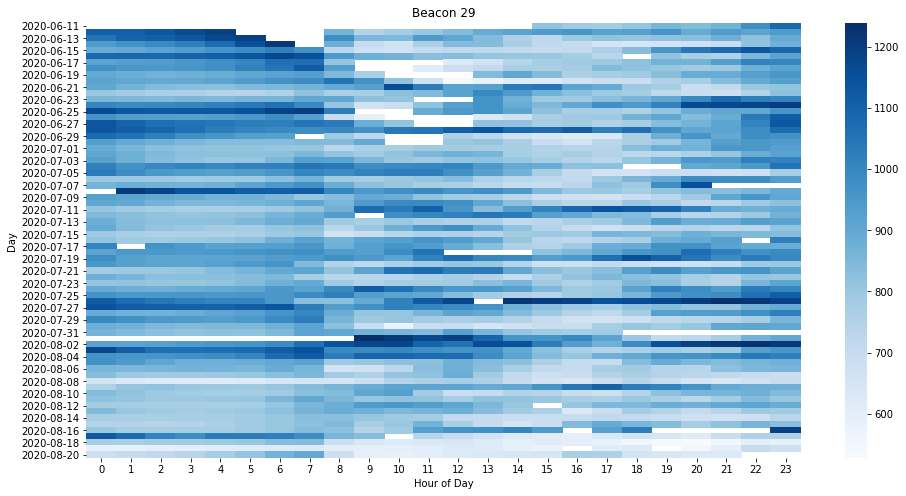

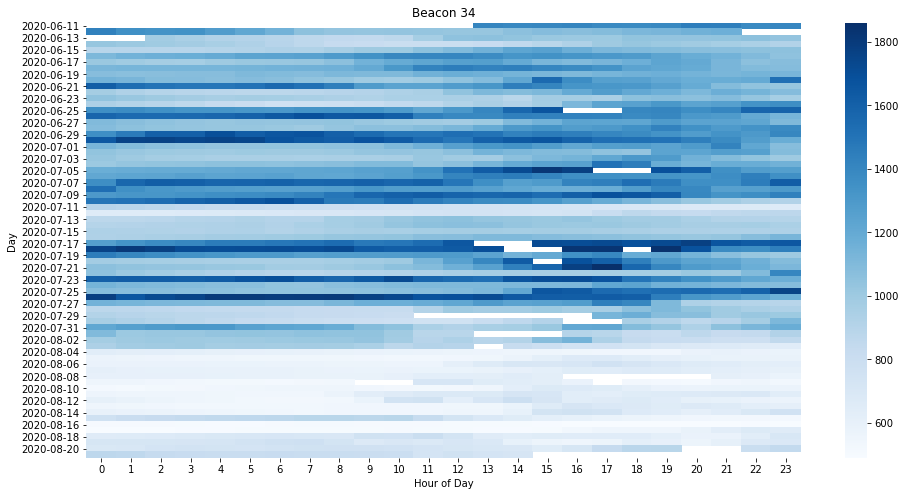

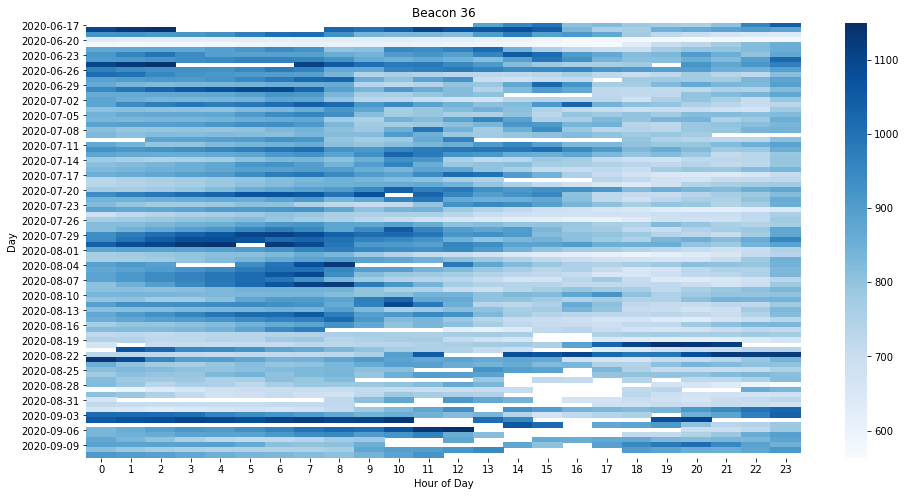

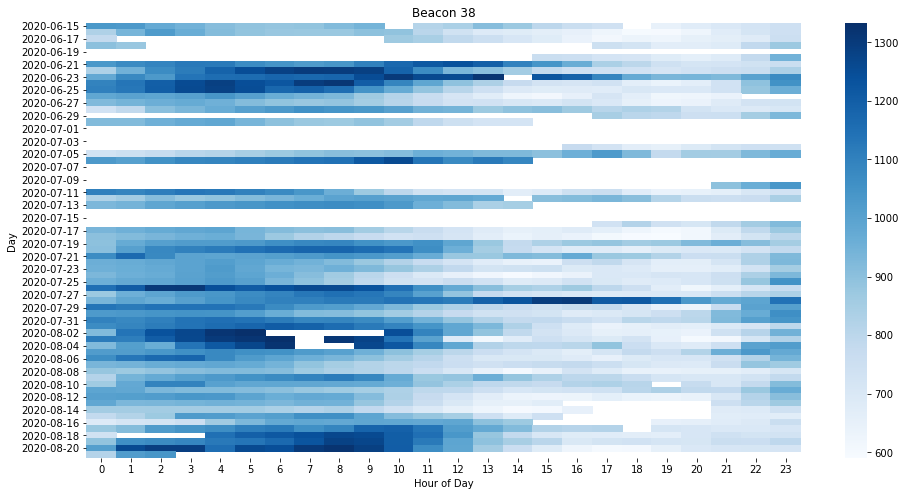

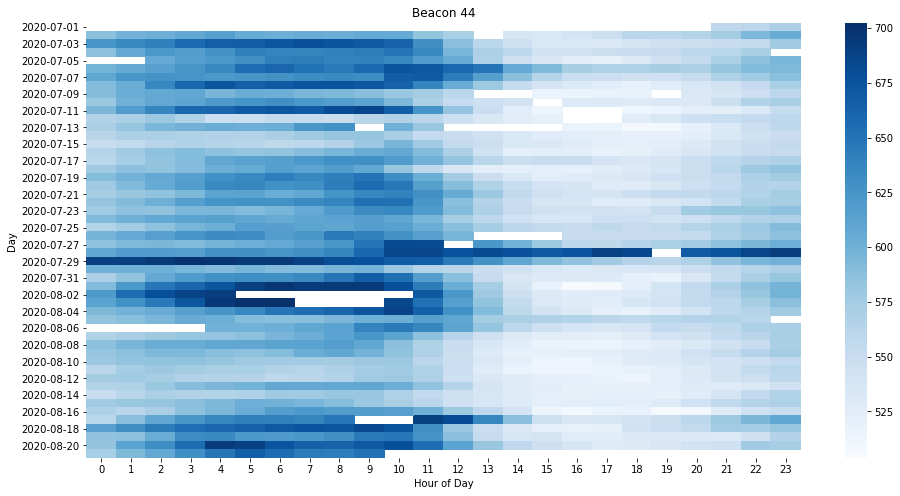

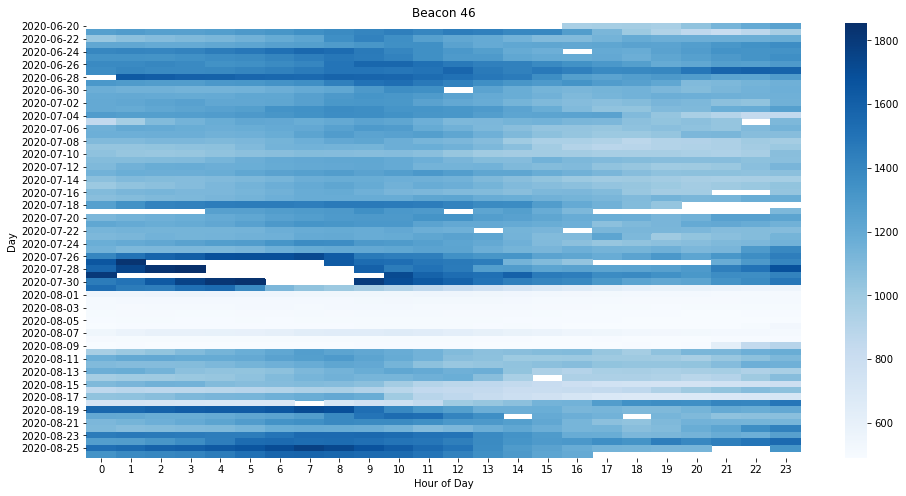

In [18]:
for bb in data["beacon"].unique():
    _ = get_table(data,bb,param="co2",plot=True)

<div class="alert-block alert alert-danger">
    
The issue with generating these tables is that we seem to have irregular gaps in the dataset making any analysis that is affected by `NaN` tricky.

</div>

# Autocorrelation
We can look at the autocorrelation function to see the variability in the data.

In [87]:
def plot_acf(df, param="co2",nlags=30,resample=False,minutes=60):
    """plots the autocorrelation figure"""
    if resample:
        df = resample_data(df,minutes=minutes)
        
    try:
        ac_vals = sm.tsa.acf(df[param].values,missing="drop",nlags=nlags)
        _, ax = plt.subplots(figsize=(nlags*0.5,4))
        ax.stem(np.arange(len(ac_vals))+1,ac_vals,markerfmt="ko",basefmt="k-")
        # x-axis
        ax.set_xlim(left=0)
        ax.set_xlabel("Lags",fontsize=14)
        # y-axis
        ax.set_ylabel("Correlation",fontsize=14)
        ax.set_ylim([-1.05,1.05])
        # remainder
        ax.tick_params(labelsize=12)
        for loc in ["top","right"]:
            ax.spines[loc].set_visible(False)

        plt.show()
        plt.close()
    except ValueError:
        print("\tNo Data to Plot")

<div class="alert-block alert alert-success">
    
* `co2`: There is a rather significant autocorrelation for about half of the beacons which is also evident by their individual heatmaps.
* `tvoc`: To a lesser extent, we see the same autocorrelations.
* `pm2p5_mass`: There are some beacons that have a small signal about 24 hours out similar to the `co2` and `tvoc` plots.
* `co`: Very few and weak autocorrelations  - mant of the plots drop off after a few lags indicative of more _random_ distributions.
* `temperature_c`: We see some significant autocorrelations again, especially when considering **Beacon 26** which has clear 12 hour cycles whereas most others are 24 hours. 
* `rh`: similar trends to `temperature_c` with less noticeable correlation. 
    
</div>